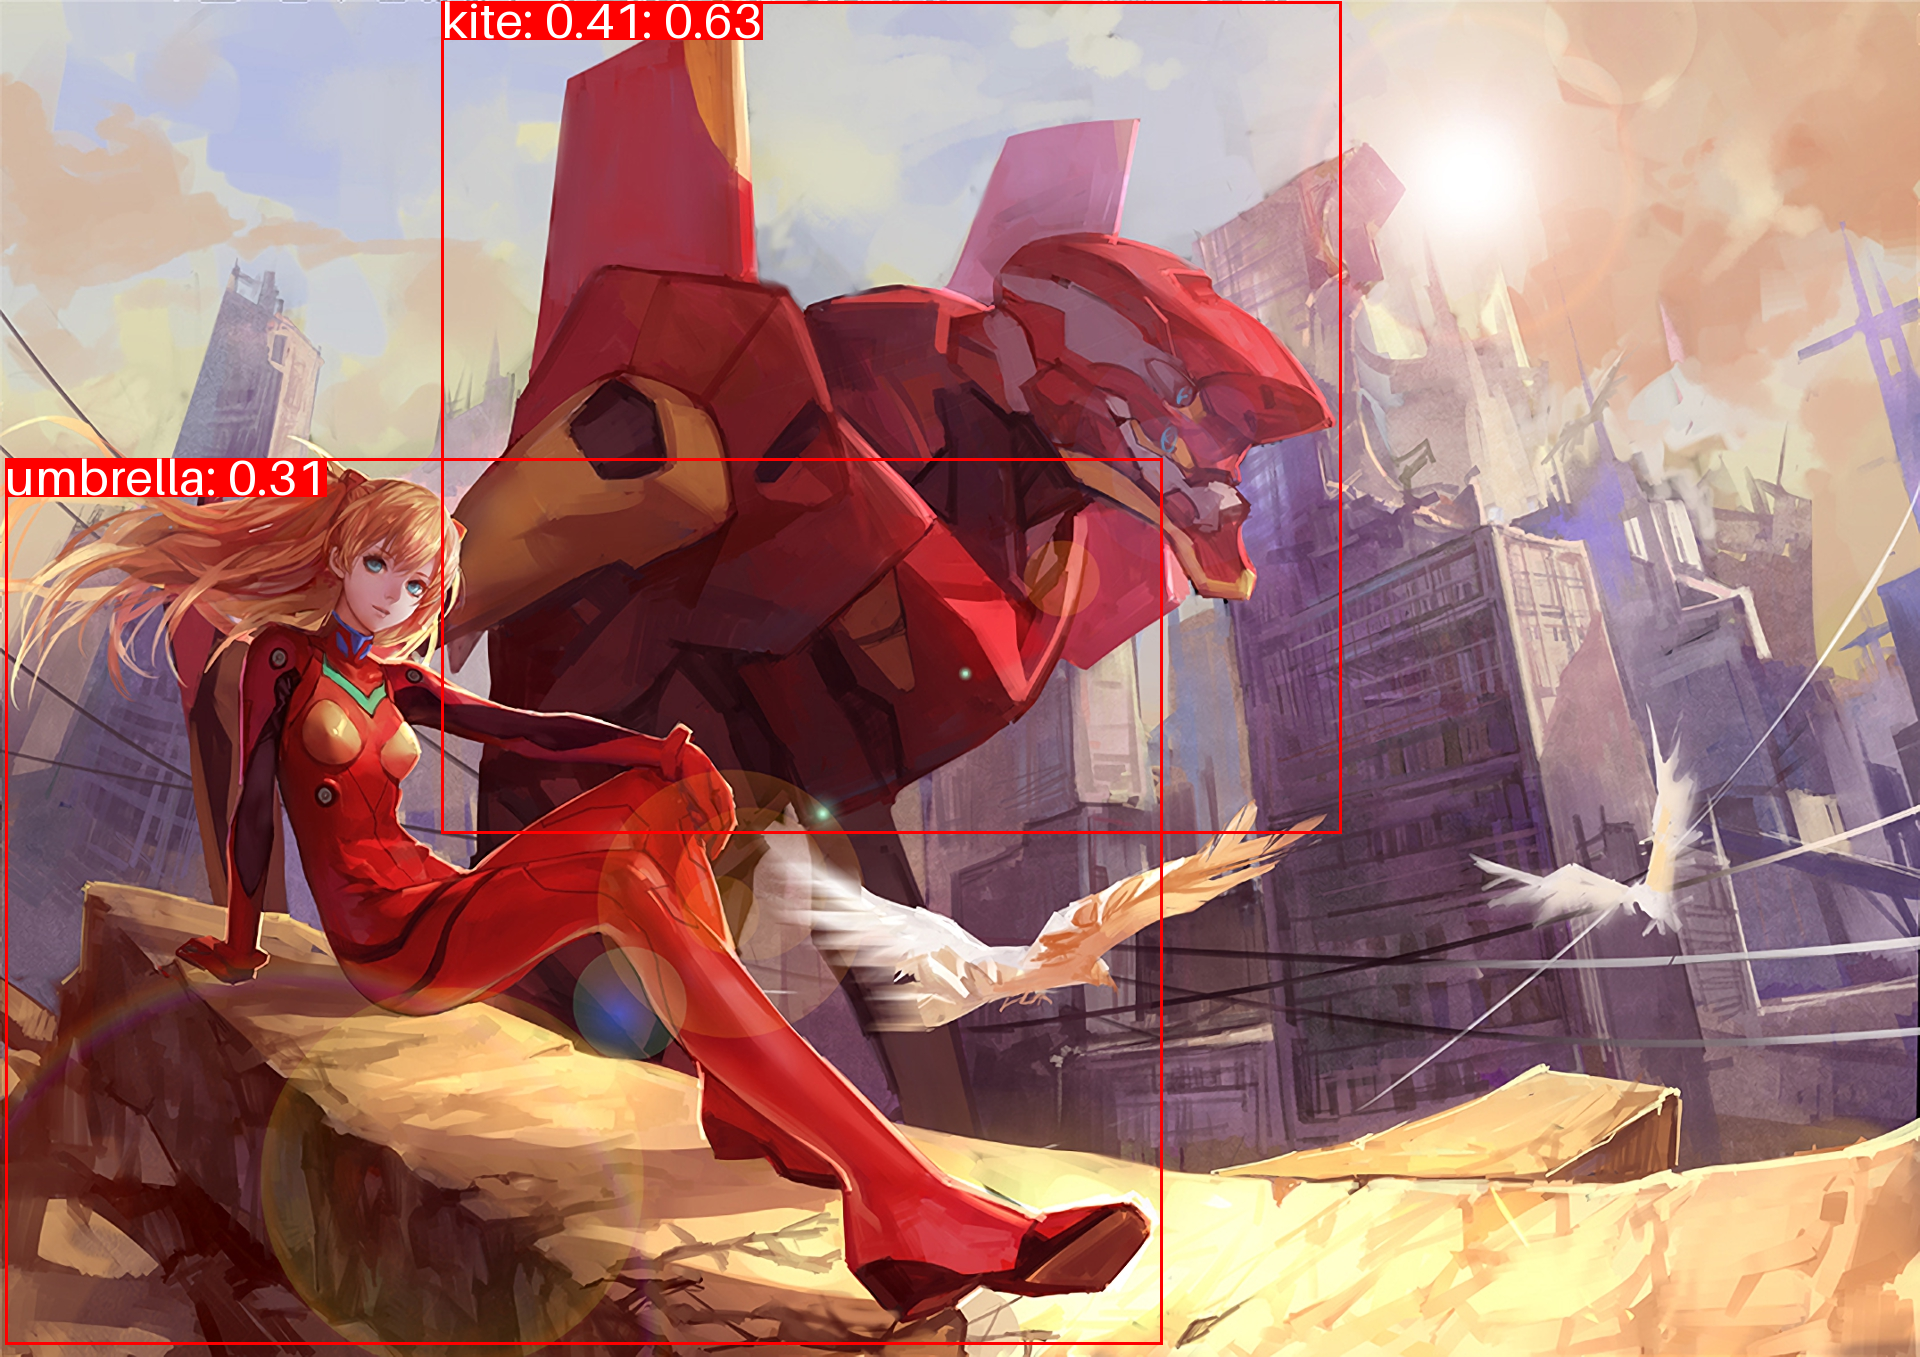

In [1]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained("PekingU/rtdetr_r18vd", cache_dir="./hf-models")
model = AutoModelForObjectDetection.from_pretrained("PekingU/rtdetr_r18vd", cache_dir="./hf-models")
model.to("cuda")
import torch
from PIL import Image, ImageDraw, ImageFont



image = Image.open(r"./images/eva.jpg")


inputs = processor(images=image, return_tensors="pt").to("cuda")


model.eval()
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])

results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.3)


def draw_result(image, box, label_text, score,color, font="", size=25):
    draw = ImageDraw.Draw(image)

    font = ImageFont.load_default(size) if not font else ImageFont.truetype(font, size)
    (left, top, right, bottom) = font.getbbox('getbbox')

    draw.rectangle(box, outline=color, width=3)
    text_bbox = draw.textbbox((box[0], box[1]), f"{label_text}: {score:.2f}", font=font)
    draw.rectangle((text_bbox[0], text_bbox[1]-top, text_bbox[2], text_bbox[3]-top), fill=color)
    draw.text((box[0], box[1]-top), f"{label_text}: {score:.2f}", fill='white', font=font)


for result in results:
    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
        
        score, label = score.item(), label_id.item()
        box = [int(i) for i in box]

        label_text = model.config.id2label[label]
        draw_result(image, box, label_text, score, "red", size=50)


image